<a href="https://colab.research.google.com/github/chrisporras/graddiss/blob/dev/Audrey_Copy_of_GradientDissentersHackathon2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hackathon 2023
ML for Biomedical Data Science
Team Gradient Dissenters

Members: Audrey Lee, Christian Porras, Joy Jiang

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
save_models_dir = "/content/drive/MyDrive/ML for BDS/Hackathon - graddiss/"

## I. Install and load Kaggle mammography

In [ ]:
# Clone project git repo
!git clone https://github.com/chrisporras/graddiss.git

Cloning into 'graddiss'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 53 (delta 27), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (53/53), 679.91 KiB | 2.51 MiB/s, done.


In [ ]:
# install Kaggle public api
! pip install -q kaggle
# Choose the kaggle.json file that you downloaded
! mkdir ~/.kaggle
! cp ./graddiss/kaggle.json ~/.kaggle/
# Make directory named kaggle and copy kaggle.json file there.
!chmod 600 ~/.kaggle/kaggle.json
#Change the permissions of the file.
! kaggle datasets list

ref                                                                title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
zusmani/pakistan-toshakhana-files                                  Pakistan ToshaKhana Files                             1MB  2023-03-15 16:25:43           2341        103  1.0              
ramkrijal/tomato-daily-prices                                      Tomato Daily Prices                                  10KB  2023-03-10 15:39:14           1315         43  1.0              
themrityunjaypathak/covid-cases-and-deaths-worldwide               Covid Cases and Deaths WorldWide                      8KB  2023-02-01 12:22:51          14485        473  1.0              
datascientistanna/customers-dataset          

In [ ]:
!kaggle competitions download -c mammography-image-patch-classification-2023

 98% 450M/460M [00:05<00:00, 86.1MB/s]
100% 460M/460M [00:05<00:00, 83.3MB/s]


In [ ]:
# data directory
!mkdir data
# unzip data there,
!unzip mammography-image-patch-classification-2023.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/train_imgs/P000435.png  
  inflating: data/train_imgs/P000436.png  
  inflating: data/train_imgs/P000437.png  
  inflating: data/train_imgs/P000438.png  
  inflating: data/train_imgs/P000439.png  
  inflating: data/train_imgs/P000440.png  
  inflating: data/train_imgs/P000441.png  
  inflating: data/train_imgs/P000442.png  
  inflating: data/train_imgs/P000443.png  
  inflating: data/train_imgs/P000444.png  
  inflating: data/train_imgs/P000445.png  
  inflating: data/train_imgs/P000446.png  
  inflating: data/train_imgs/P000447.png  
  inflating: data/train_imgs/P000448.png  
  inflating: data/train_imgs/P000449.png  
  inflating: data/train_imgs/P000450.png  
  inflating: data/train_imgs/P000451.png  
  inflating: data/train_imgs/P000452.png  
  inflating: data/train_imgs/P000453.png  
  inflating: data/train_imgs/P000454.png  
  inflating: data/train_imgs/P000455.png  
  inflating: data/train_imgs/P000456.png  
  i

## II. Prepare data.
### A. Create datasets.

In [ ]:
# Configuration class
class Config:
    resize = False
    batch_size = 32
    numworkers = 2

In [ ]:
# CustomImageDataset class
import os
from PIL import Image
import torchvision
from skimage import io, img_as_float32
import numpy as np
import torch
from skimage.io import imread

class ToTensor3D(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, image):
        image = img_as_float32(image)
        # The following two lines are to duplicate the grayscale image onto
        # 3 channels. That's to make the input compatible with those models
        # trained on color images. If you don't use pretrained models, you can
        # delete these two lines.
        new_shape = (3,) + image.shape
        dup_img = np.broadcast_to(image, new_shape)

        return torch.from_numpy(dup_img.copy())

class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, df, transform=None, testset=False):
        # Create one iterable that get be __getitemed__
        self.image_dir = image_dir
        self.df = df
        self.transform = transform # added transform
        self.testset = testset

    def __len__(self): # Denotes the total number of samples
        # return self.df.shape[0] # orig
        return len(self.df) # try this

    # added this for normalization: https://towardsdatascience.com/train-a-neural-network-to-detect-breast-mri-tumors-with-pytorch-250a02be7777
    def normalize(self, image):
      image = image.astype(float) * 255. / image.max()
      # Convert float --> uint8. This maps pixel intensities from 0 to 255
      # Source: above and here: https://scikit-image.org/docs/stable/user_guide/data_types.html
      image = image.astype(np.uint8)
      return image

    def __getitem__(self, index): # Generates one sample of data
        
        # added this
        if torch.is_tensor(index):
          index = index.tolist()

        # Goes to image_tensor below
        image_path = os.path.join(self.image_dir, self.df.iloc[index]['img_name'])
        # image_og = Image.open(image_path)
        image_og = imread(image_path) # read in png or jpg

        # Normalize image
        image = self.normalize(image_og)

        # Convert to 3D tensor
        t = ToTensor3D()
        image = t(image)

        if self.transform:
          image = self.transform(image)
          # image = self.transform(image_og)

        # ??????Not sure about the dtype=torch.long
        # Test set has no label_num
        if not(self.testset):
          label = torch.tensor(self.df.iloc[index]['label_num'],dtype=torch.long)
        else:
          label = self.df.iloc[index]['id'] 

        # Resize, depending on the network ?????Not sure about this
        if Config.resize:
            resize = torchvision.transforms.Resize(384)
            image = resize(image)
        
        return image, label

In [ ]:
import pandas as pd

# New numeric labels.
labels_num = {'background': 0, 'calc_ben': 1, 'calc_mal': 2, 
              'mass_ben': 3, 'mass_mal': 4}

# Read image metadata
traindf = pd.read_csv('data/train.csv') 
traindf['label_num'] = traindf['label'].map(labels_num)


testdf = pd.read_csv('data/test.csv')

print(traindf)
print()
print(testdf)

           id       label     img_name  label_num
0     P000001    calc_ben  P000001.png          1
1     P000002    calc_ben  P000002.png          1
2     P000003    mass_ben  P000003.png          3
3     P000004    mass_mal  P000004.png          4
4     P000005    calc_mal  P000005.png          2
...       ...         ...          ...        ...
5429  P005430  background  P005430.png          0
5430  P005431    calc_mal  P005431.png          2
5431  P005432    calc_ben  P005432.png          1
5432  P005433  background  P005433.png          0
5433  P005434    calc_mal  P005434.png          2

[5434 rows x 4 columns]

           id     img_name
0     P100000  P100000.png
1     P100001  P100001.png
2     P100002  P100002.png
3     P100003  P100003.png
4     P100004  P100004.png
...       ...          ...
1230  P101230  P101230.png
1231  P101231  P101231.png
1232  P101232  P101232.png
1233  P101233  P101233.png
1234  P101234  P101234.png

[1235 rows x 2 columns]


In [ ]:
# Get how many in each label category
traindf.groupby(["label_num"]).count()

,id,label,img_name
label_num,,,
0,2495,2495,2495
1,1042,1042,1042
2,579,579,579
3,681,681,681
4,637,637,637


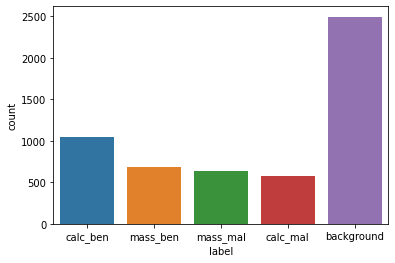

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the different classes
fig, ax = plt.subplots()
ax = sns.countplot(data=traindf,
                   x="label")


In [ ]:
num_labels = {v:k for k,v in labels_num.items()}
num_labels

{0: 'background', 1: 'calc_ben', 2: 'calc_mal', 3: 'mass_ben', 4: 'mass_mal'}

In [ ]:
from torchvision import datasets, transforms

# Define transforms I want to use
data_transforms = {
  "train": transforms.Compose([
      transforms.Resize((224,224)),
      # transforms.Resize(256),
      # transforms.CenterCrop(224),
      # transforms.RandomResizedCrop(224), # Some data augmentation --> get rid of? Seems to get padded areas
      transforms.RandomHorizontalFlip(), # Some data augmentation
      transforms.RandomVerticalFlip(), # Data augmentation
      transforms.RandomRotation(25), # Data augmentation
      transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ]),

  "val": transforms.Compose([
      transforms.Resize((224,224)),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
  "test": transforms.Compose([
      transforms.Resize((224,224)),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])
}

Before addressing class imbalance, note how each batch had so much more "background"

In [ ]:
# BEFORE ADDRESSING CLASS IMBALANCE
# Make datasets 

# train_dataset = CustomImageDataset('data/train_imgs', traindf, 
#                                    transform=data_transforms["train"])

# train_size = int(0.5 * len(train_dataset))
# val_size = len(train_dataset) - train_size
# train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, 
#                                                      [train_size, val_size])

# test_dataset = CustomImageDataset('data/test_imgs', testdf)

# # Make dataloaders
# train_loader = torch.utils.data.DataLoader(train_dataset, Config.batch_size, 
#                                            shuffle=True, num_workers=Config.numworkers)

# val_loader = torch.utils.data.DataLoader(val_dataset, Config.batch_size, 
#                                          shuffle=True, num_workers=Config.numworkers)

# # Build batches - check distribution of classes per batch
# for step, (img,label) in enumerate(train_loader):
#   print("batch index {}, 0/1/2/3/4: {}/{}/{}/{}/{}".format(step,
#                                                            len(np.where(label.numpy() == 0)[0]),
#                                                            len(np.where(label.numpy() == 1)[0]),
#                                                            len(np.where(label.numpy() == 2)[0]),
#                                                            len(np.where(label.numpy() == 3)[0]),
#                                                            len(np.where(label.numpy() == 4)[0]))
#   )

# # Putting these into a dict format for compatibility with the train function later
# dataloaders = {"train": train_loader,
#                "val": val_loader
#                }

# dataset_sizes = {"train": len(train_dataset),
#                  "val": len(val_dataset)
#                  }

### Try by addressing class imbalance

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler

# Want to create separate training and validation datasets, each having their
# own transformations. We also want to prevent leakage!

# First create the original train dataset
orig_train_dataset = CustomImageDataset('data/train_imgs', traindf, 
                                   transform=data_transforms["train"])
# Create the original val dataset, which is a copy of the orig_train_dataset, but
# with a different set of transformations
orig_val_dataset = CustomImageDataset('data/train_imgs', traindf, 
                                   transform=data_transforms["val"])

# Split the orig_train_dataset into preliminary train and val datasets
train_size = int(0.5 * len(orig_train_dataset))
val_size = len(orig_train_dataset) - train_size
train_dataset, temp_val_dataset = torch.utils.data.random_split(orig_train_dataset, 
                                                     [train_size, val_size])
# Get the indices for the data that belongs to the temp_val_dataset, and use it 
# to subset the orig_val_dataset
val_dataset = torch.utils.data.Subset(orig_val_dataset, temp_val_dataset.indices)

test_dataset = CustomImageDataset('data/test_imgs', testdf, 
                                  transform=data_transforms["test"],
                                  testset=True)

In [ ]:
# Making sure there is no overlap to avoid data leakage into val --> should be False if no overlap
bool(set(val_dataset.indices) & set(train_dataset.indices))

False

In [ ]:
# Addressing class imbalance by weighting samples 
# Shen: The sample weights were adjusted within each batch to balance the five classes.
y_train = [orig_train_dataset.df.loc[i]["label_num"] for i in train_dataset.indices]
class_sample_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in y_train])
samples_weight = torch.from_numpy(samples_weight)

# sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

# Remake the train dataloader
train_loader = DataLoader(train_dataset, sampler=sampler, batch_size=Config.batch_size,
                          num_workers=Config.numworkers)
val_loader = torch.utils.data.DataLoader(val_dataset, Config.batch_size, 
                                         shuffle=True, num_workers=Config.numworkers)
test_loader = torch.utils.data.DataLoader(test_dataset, Config.batch_size, 
                                         shuffle=False)
# # Build batches - check distribution of classes per batch
# for step, (img,label) in enumerate(train_loader):
#   print("batch index {}, 0/1/2/3/4: {}/{}/{}/{}/{}".format(step,
#                                                            len(np.where(label.numpy() == 0)[0]),
#                                                            len(np.where(label.numpy() == 1)[0]),
#                                                            len(np.where(label.numpy() == 2)[0]),
#                                                            len(np.where(label.numpy() == 3)[0]),
#                                                            len(np.where(label.numpy() == 4)[0]))
#   )



# Putting these into a dict format for easier use later
dataloaders = {"train": train_loader,
               "val": val_loader,
               "test": test_loader
               }

dataset_sizes = {"train": len(train_dataset),
                 "val": len(val_dataset),
                 "test": len(test_dataset)
                 }

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

Using device:  cuda:0


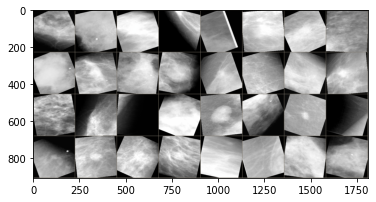

In [ ]:
import matplotlib.pyplot as plt
from skimage import io, img_as_float32
import numpy as np
import torch

# To get one image:
# temp_img, temp_lab = train_dataset[0]
# print(temp_img.shape)
# imshow(temp_img, title=num_labels[temp_lab.item()])
# plt.title(num_labels[temp_lab.item()])

# To get a batch of images
temp_img, temp_lab = next(iter(dataloaders["train"]))
# Make a grid from batch
out = torchvision.utils.make_grid(temp_img)
imshow(out)
# imshow(out, title=[num_labels[x.item()] for x in temp_lab])

plt.show()

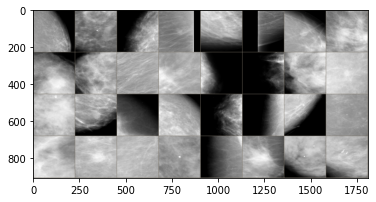

In [ ]:
# To get a batch of images
temp_img, temp_lab = next(iter(dataloaders["val"]))
# Make a grid from batch
out = torchvision.utils.make_grid(temp_img)
imshow(out)
# imshow(out, title=[num_labels[x.item()] for x in temp_lab])

plt.show()

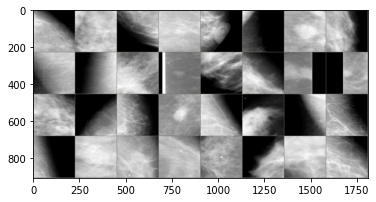

In [ ]:
# To get a batch of images
temp_img, temp_lab = next(iter(dataloaders["test"]))
# Make a grid from batch
out = torchvision.utils.make_grid(temp_img)
imshow(out)
# imshow(out, title=[num_labels[x.item()] for x in temp_lab])

plt.show()

# Setting up training functions

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # # For book-keeping the losses and accuracies
    # epoch_ls = []
    # train_loss_ls = []
    # val_loss_ls = []
    # train_acc_ls = []
    # val_acc_ls = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {num_labels[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Try ResNet50 
Read from bottom up, since most updated model training is higher up.

## Multi-phase training approach with progressive unfreezing of layers

### Stage 1

In [ ]:
resnet50_model = models.resnet50(weights="DEFAULT")

# Freeze all parameters...except for the final layer
for param in resnet50_model.parameters():
    param.requires_grad = False
num_ftrs = resnet50_model.fc.in_features
resnet50_model.fc = nn.Linear(num_ftrs, 5)

resnet50_model = resnet50_model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized --> change for each stage
optimizer = optim.Adam(resnet50_model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 10 epochs
# If don't want to decay, then set the step_size to very high
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
resnet50_model = train_model(resnet50_model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=3)

Epoch 0/2
----------
train Loss: 1.4885 Acc: 0.3636
val Loss: 1.3313 Acc: 0.5123

Epoch 1/2
----------
train Loss: 1.3827 Acc: 0.4461
val Loss: 1.1956 Acc: 0.5539

Epoch 2/2
----------
train Loss: 1.3193 Acc: 0.4604
val Loss: 1.2024 Acc: 0.5348

Training complete in 2m 49s
Best val Acc: 0.553920


### Stage 2

In [ ]:
# For simplicity, first unfreeze all layers
for param in resnet50_model.parameters():
    param.requires_grad = True

In [ ]:
resnet50_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
layer_count = 0
for child in resnet50_model.children():
  print("Child ", layer_count)
  print(child)
  children_of_child_counter = 0
  for children_of_child in child.children():
    print("child ", children_of_child_counter, "of child", layer_count)
    print(children_of_child)
    children_of_child_counter += 1 
  layer_count += 1

# print("total layers: ", layer_count)


Child  0
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Child  1
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Child  2
ReLU(inplace=True)
Child  3
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Child  4
Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d

In [ ]:
# Now selectively freeze layers
child_counter = 0
for child in resnet50_model.children():
  if child_counter < 7:
    print("child", child_counter, "was frozen")
    for param in child.parameters():
      param.requires_grad = False
  elif child_counter == 7:
    children_of_child_counter = 0
    for children_of_child in child.children():
      if children_of_child_counter < 2:
        for param in children_of_child.parameters():
          param.requires_grad = False
        print("child", children_of_child_counter, "of child", child_counter, "was frozen")
      else:
        print('child ', children_of_child_counter, 'of child',child_counter,' was not frozen')
      children_of_child_counter += 1
  else:
    print("child ",child_counter," was not frozen")
  child_counter += 1
    
    # print("child ",child_counter," was frozen")
    # for param in child.parameters():
    #     param.requires_grad = False

child 0 was frozen
child 1 was frozen
child 2 was frozen
child 3 was frozen
child 4 was frozen
child 5 was frozen
child 6 was frozen
child 0 of child 7 was frozen
child 1 of child 7 was frozen
child  2 of child 7  was not frozen
child  8  was not frozen
child  9  was not frozen


In [ ]:
resnet50_model = resnet50_model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized --> change for each stage
optimizer = optim.Adam(resnet50_model.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 10 epochs
# If don't want to decay, then set the step_size to very high
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=11, gamma=0.1)

In [ ]:
resnet50_model = train_model(resnet50_model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 1.2893 Acc: 0.4803
val Loss: 1.1549 Acc: 0.5565

Epoch 1/9
----------
train Loss: 1.2117 Acc: 0.5072
val Loss: 1.0484 Acc: 0.5889

Epoch 2/9
----------
train Loss: 1.1480 Acc: 0.5469
val Loss: 1.0121 Acc: 0.6069

Epoch 3/9
----------
train Loss: 1.1020 Acc: 0.5558
val Loss: 0.9959 Acc: 0.6242

Epoch 4/9
----------
train Loss: 1.0805 Acc: 0.5558
val Loss: 0.9762 Acc: 0.6235

Epoch 5/9
----------
train Loss: 1.0583 Acc: 0.5709
val Loss: 0.9677 Acc: 0.6378

Epoch 6/9
----------
train Loss: 1.0377 Acc: 0.5760
val Loss: 0.9219 Acc: 0.6511

Epoch 7/9
----------
train Loss: 1.0069 Acc: 0.5915
val Loss: 0.9754 Acc: 0.6216

Epoch 8/9
----------
train Loss: 1.0107 Acc: 0.5859
val Loss: 0.9803 Acc: 0.6286

Epoch 9/9
----------
train Loss: 1.0053 Acc: 0.6080
val Loss: 0.9406 Acc: 0.6334

Training complete in 9m 13s
Best val Acc: 0.651086


### Stage 3

In [ ]:
# Unfreeze all parameters
for param in resnet50_model.parameters():
    param.requires_grad = True

resnet50_model = resnet50_model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized --> change for each stage
optimizer = optim.Adam(resnet50_model.parameters(), lr=0.00001)

# Decay LR by a factor of 0.1 every 10 epochs
# If don't want to decay, then set the step_size to very high
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

In [ ]:
resnet50_model = train_model(resnet50_model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=37)

Epoch 0/36
----------
train Loss: 0.9882 Acc: 0.6058
val Loss: 0.8974 Acc: 0.6618

Epoch 1/36
----------
train Loss: 0.9340 Acc: 0.6308
val Loss: 0.8735 Acc: 0.6669

Epoch 2/36
----------
train Loss: 0.9258 Acc: 0.6264
val Loss: 0.8486 Acc: 0.6772

Epoch 3/36
----------
train Loss: 0.8934 Acc: 0.6445
val Loss: 0.8423 Acc: 0.6791

Epoch 4/36
----------
train Loss: 0.8747 Acc: 0.6544
val Loss: 0.8970 Acc: 0.6570

Epoch 5/36
----------
train Loss: 0.8586 Acc: 0.6573
val Loss: 0.8144 Acc: 0.6956

Epoch 6/36
----------
train Loss: 0.8128 Acc: 0.6824
val Loss: 0.7678 Acc: 0.7137

Epoch 7/36
----------
train Loss: 0.7592 Acc: 0.6975
val Loss: 0.8007 Acc: 0.7008

Epoch 8/36
----------
train Loss: 0.7818 Acc: 0.6838
val Loss: 0.7590 Acc: 0.7177

Epoch 9/36
----------
train Loss: 0.7325 Acc: 0.6982
val Loss: 0.7519 Acc: 0.7203

Epoch 10/36
----------
train Loss: 0.7420 Acc: 0.7089
val Loss: 0.7492 Acc: 0.7195

Epoch 11/36
----------
train Loss: 0.6979 Acc: 0.7159
val Loss: 0.7358 Acc: 0.7199

Ep

In [ ]:
# Save the best model --> checkpoint
torch.save(resnet50_model.state_dict(), 
           save_models_dir + "best_resnet50_multistage_train.pt")

Continue with the above, so going to 100 epochs

In [ ]:
resnet50_model = train_model(resnet50_model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=50)

Epoch 0/49
----------
train Loss: 0.4078 Acc: 0.8476
val Loss: 0.6840 Acc: 0.7586

Epoch 1/49
----------
train Loss: 0.3722 Acc: 0.8627
val Loss: 0.6709 Acc: 0.7622

Epoch 2/49
----------
train Loss: 0.3637 Acc: 0.8668
val Loss: 0.6854 Acc: 0.7611

Epoch 3/49
----------
train Loss: 0.3626 Acc: 0.8653
val Loss: 0.6646 Acc: 0.7648

Epoch 4/49
----------
train Loss: 0.3472 Acc: 0.8800
val Loss: 0.6832 Acc: 0.7670

Epoch 5/49
----------
train Loss: 0.3416 Acc: 0.8734
val Loss: 0.6845 Acc: 0.7644

Epoch 6/49
----------
train Loss: 0.3365 Acc: 0.8763
val Loss: 0.7069 Acc: 0.7667

Epoch 7/49
----------
train Loss: 0.3579 Acc: 0.8671
val Loss: 0.6753 Acc: 0.7696

Epoch 8/49
----------
train Loss: 0.3174 Acc: 0.8837
val Loss: 0.7006 Acc: 0.7637

Epoch 9/49
----------
train Loss: 0.3093 Acc: 0.8929
val Loss: 0.6888 Acc: 0.7755

Epoch 10/49
----------
train Loss: 0.2931 Acc: 0.8914
val Loss: 0.7001 Acc: 0.7648

Epoch 11/49
----------
train Loss: 0.2829 Acc: 0.8966
val Loss: 0.7060 Acc: 0.7703

Ep

In [ ]:
# Save the best model --> checkpoint
torch.save(resnet50_model.state_dict(), 
           save_models_dir + "best_resnet50_multistage_train.pt")

Keep...going...(150 epochs)

In [ ]:
resnet50_model = train_model(resnet50_model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=50)

Epoch 0/49
----------
train Loss: 0.2426 Acc: 0.9172
val Loss: 0.7228 Acc: 0.7670

Epoch 1/49
----------
train Loss: 0.2324 Acc: 0.9216
val Loss: 0.7220 Acc: 0.7692

Epoch 2/49
----------
train Loss: 0.2195 Acc: 0.9264
val Loss: 0.7093 Acc: 0.7784

Epoch 3/49
----------
train Loss: 0.2277 Acc: 0.9124
val Loss: 0.7207 Acc: 0.7751

Epoch 4/49
----------
train Loss: 0.2209 Acc: 0.9268
val Loss: 0.7239 Acc: 0.7652

Epoch 5/49
----------
train Loss: 0.2331 Acc: 0.9220
val Loss: 0.7302 Acc: 0.7644

Epoch 6/49
----------
train Loss: 0.2514 Acc: 0.9084
val Loss: 0.7318 Acc: 0.7736

Epoch 7/49
----------
train Loss: 0.2234 Acc: 0.9234
val Loss: 0.7202 Acc: 0.7722

Epoch 8/49
----------
train Loss: 0.2176 Acc: 0.9290
val Loss: 0.7201 Acc: 0.7736

Epoch 9/49
----------
train Loss: 0.2315 Acc: 0.9183
val Loss: 0.7291 Acc: 0.7703

Epoch 10/49
----------
train Loss: 0.2199 Acc: 0.9279
val Loss: 0.7208 Acc: 0.7788

Epoch 11/49
----------
train Loss: 0.2391 Acc: 0.9165
val Loss: 0.7119 Acc: 0.7751

Ep

Is it possible to pop out of a local minima?

In [ ]:
# Observe that all parameters are being optimized --> change for each stage
optimizer = optim.Adam(resnet50_model.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 10 epochs
# If don't want to decay, then set the step_size to very high
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

In [ ]:
resnet50_model = train_model(resnet50_model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4094 Acc: 0.8439
val Loss: 0.8726 Acc: 0.7114

Epoch 1/24
----------
train Loss: 0.4034 Acc: 0.8506
val Loss: 0.7413 Acc: 0.7460

Epoch 2/24
----------
train Loss: 0.3636 Acc: 0.8690
val Loss: 0.8714 Acc: 0.7111

Epoch 3/24
----------
train Loss: 0.3238 Acc: 0.8815
val Loss: 0.7631 Acc: 0.7512

Epoch 4/24
----------
train Loss: 0.2946 Acc: 0.8881
val Loss: 0.8012 Acc: 0.7563

Epoch 5/24
----------
train Loss: 0.2676 Acc: 0.9021
val Loss: 0.8877 Acc: 0.7446

Epoch 6/24
----------
train Loss: 0.2777 Acc: 0.9017
val Loss: 0.7746 Acc: 0.7575

Epoch 7/24
----------
train Loss: 0.2391 Acc: 0.9131
val Loss: 0.8625 Acc: 0.7332

Epoch 8/24
----------
train Loss: 0.2177 Acc: 0.9172
val Loss: 0.8090 Acc: 0.7644

Epoch 9/24
----------
train Loss: 0.2020 Acc: 0.9257
val Loss: 0.8628 Acc: 0.7468

Epoch 10/24
----------
train Loss: 0.1783 Acc: 0.9341
val Loss: 0.8273 Acc: 0.7711

Epoch 11/24
----------
train Loss: 0.1846 Acc: 0.9356
val Loss: 0.8500 Acc: 0.7589

Ep

In [ ]:
# Save the best model
torch.save(resnet50_model.state_dict(), 
           save_models_dir + "best_resnet50_multistage_train_incrLRlate.pt")

## With separate train and validation data transforms. Increased train data augmentations with training-only transforms. And previous features (Adam Optim + Address Class Imbalance)

In [ ]:
model_ft = models.resnet50(weights="DEFAULT")
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.4243 Acc: 0.4218
val Loss: 1.2147 Acc: 0.5661

Epoch 1/24
----------
train Loss: 0.9581 Acc: 0.6143
val Loss: 0.8882 Acc: 0.6768

Epoch 2/24
----------
train Loss: 0.7908 Acc: 0.7011
val Loss: 0.7619 Acc: 0.7151

Epoch 3/24
----------
train Loss: 0.6667 Acc: 0.7321
val Loss: 0.7221 Acc: 0.7247

Epoch 4/24
----------
train Loss: 0.5804 Acc: 0.7781
val Loss: 0.7499 Acc: 0.7173

Epoch 5/24
----------
train Loss: 0.5681 Acc: 0.7755
val Loss: 0.6627 Acc: 0.7604

Epoch 6/24
----------
train Loss: 0.4890 Acc: 0.8116
val Loss: 0.6639 Acc: 0.7586

Epoch 7/24
----------
train Loss: 0.4474 Acc: 0.8307
val Loss: 0.6518 Acc: 0.7714

Epoch 8/24
----------
train Loss: 0.4122 Acc: 0.8480
val Loss: 0.6306 Acc: 0.7740

Epoch 9/24
----------
train Loss: 0.3784 Acc: 0.8568
val Loss: 0.7550 Acc: 0.7357

Epoch 10/24
----------
train Loss: 0.2972 Acc: 0.8866
val Loss: 0.6556 Acc: 0.7733

Epoch 11/24
----------
train Loss: 0.2967 Acc: 0.8911
val Loss: 0.6457 Acc: 0.7770

Ep

In [ ]:
# Save the best model
torch.save(model_ft.state_dict(), '/content/drive/MyDrive/ML for BDS/Hackathon - graddiss/best_resnet50_balanced_AdamOptim.pt')

## With the RandomWeightedSample (i.e. addressing class imbalance) + Adam Optimizer

In [ ]:
model_ft = models.resnet50(weights="DEFAULT")
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.3826 Acc: 0.4682
val Loss: 1.4448 Acc: 0.4269

Epoch 1/24
----------
train Loss: 0.8711 Acc: 0.6989
val Loss: 0.9535 Acc: 0.6511

Epoch 2/24
----------
train Loss: 0.5757 Acc: 0.7968
val Loss: 0.8412 Acc: 0.6835

Epoch 3/24
----------
train Loss: 0.3476 Acc: 0.8929
val Loss: 0.8667 Acc: 0.7067

Epoch 4/24
----------
train Loss: 0.2713 Acc: 0.9124
val Loss: 0.8027 Acc: 0.7206

Epoch 5/24
----------
train Loss: 0.1595 Acc: 0.9547
val Loss: 0.8914 Acc: 0.7236

Epoch 6/24
----------
train Loss: 0.1518 Acc: 0.9533
val Loss: 0.8893 Acc: 0.7192

Epoch 7/24
----------
train Loss: 0.1182 Acc: 0.9647
val Loss: 0.8691 Acc: 0.7306

Epoch 8/24
----------
train Loss: 0.0703 Acc: 0.9779
val Loss: 1.0150 Acc: 0.7328

Epoch 9/24
----------
train Loss: 0.0557 Acc: 0.9838
val Loss: 0.9582 Acc: 0.7357

Epoch 10/24
----------
train Loss: 0.0531 Acc: 0.9845
val Loss: 0.9877 Acc: 0.7527

Epoch 11/24
----------
train Loss: 0.0314 Acc: 0.9919
val Loss: 1.0010 Acc: 0.7516

Ep

In [ ]:
# Save the best model
torch.save(model_ft.state_dict(), '/content/drive/MyDrive/ML for BDS/Hackathon - graddiss/best_resnet50_balanced_AdamOptim.pt')

## With preliminary class balancing using a RandomWeightedSample (see above)

In [ ]:
model_ft = models.resnet50(weights="DEFAULT")
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.5758 Acc: 0.2827
val Loss: 1.5102 Acc: 0.4895

Epoch 1/24
----------
train Loss: 1.4501 Acc: 0.4008
val Loss: 1.3647 Acc: 0.4895

Epoch 2/24
----------
train Loss: 1.3602 Acc: 0.4623
val Loss: 1.2716 Acc: 0.5215

Epoch 3/24
----------
train Loss: 1.2926 Acc: 0.4807
val Loss: 1.2811 Acc: 0.5285

Epoch 4/24
----------
train Loss: 1.2216 Acc: 0.5392
val Loss: 1.2410 Acc: 0.5326

Epoch 5/24
----------
train Loss: 1.1188 Acc: 0.5709
val Loss: 1.1484 Acc: 0.5661

Epoch 6/24
----------
train Loss: 1.0317 Acc: 0.6301
val Loss: 1.0408 Acc: 0.6032

Epoch 7/24
----------
train Loss: 0.9633 Acc: 0.6445
val Loss: 1.0629 Acc: 0.5918

Epoch 8/24
----------
train Loss: 0.8968 Acc: 0.6699
val Loss: 0.9713 Acc: 0.6275

Epoch 9/24
----------
train Loss: 0.7644 Acc: 0.7302
val Loss: 0.9305 Acc: 0.6378

Epoch 10/24
----------
train Loss: 0.7036 Acc: 0.7523
val Loss: 0.9019 Acc: 0.6456

Epoch 11/24
----------
train Loss: 0.6986 Acc: 0.7622
val Loss: 0.8945 Acc: 0.6529

Ep

In [ ]:
# Save the best model
torch.save(model_ft.state_dict(), '/content/drive/MyDrive/ML for BDS/Hackathon - graddiss/best_resnet50_balanced_model.pt')

## The following is 50 epochs, preliminary balanced dataset, and SGD optimizer 

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50)

Epoch 0/49
----------
train Loss: 1.5786 Acc: 0.2867
val Loss: 1.5297 Acc: 0.3828

Epoch 1/49
----------
train Loss: 1.4890 Acc: 0.3563
val Loss: 1.3771 Acc: 0.4505

Epoch 2/49
----------
train Loss: 1.4008 Acc: 0.4085
val Loss: 1.3282 Acc: 0.4796

Epoch 3/49
----------
train Loss: 1.3996 Acc: 0.4148
val Loss: 1.2348 Acc: 0.5013

Epoch 4/49
----------
train Loss: 1.3535 Acc: 0.4442
val Loss: 1.2306 Acc: 0.5098

Epoch 5/49
----------
train Loss: 1.3219 Acc: 0.4619
val Loss: 1.1829 Acc: 0.5370

Epoch 6/49
----------
train Loss: 1.2694 Acc: 0.4902
val Loss: 1.2848 Acc: 0.5098

Epoch 7/49
----------
train Loss: 1.2611 Acc: 0.4925
val Loss: 1.1739 Acc: 0.5477

Epoch 8/49
----------
train Loss: 1.2176 Acc: 0.5090
val Loss: 1.1132 Acc: 0.5697

Epoch 9/49
----------
train Loss: 1.1562 Acc: 0.5425
val Loss: 1.0910 Acc: 0.5841

Epoch 10/49
----------
train Loss: 1.1426 Acc: 0.5561
val Loss: 1.0720 Acc: 0.5852

Epoch 11/49
----------
train Loss: 1.1188 Acc: 0.5657
val Loss: 1.0427 Acc: 0.6077

Ep

In [ ]:
# Save the best model
torch.save(model_ft.state_dict(), '/content/drive/MyDrive/ML for BDS/Hackathon - graddiss/best_resnet50_balanced_model_50epochs.pt')

## Older code for 25 epochs (not yet addressing class imbalance)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.5717 Acc: 0.2908
val Loss: 1.4866 Acc: 0.4468

Epoch 1/24
----------
train Loss: 1.4874 Acc: 0.3658
val Loss: 1.3742 Acc: 0.4707

Epoch 2/24
----------
train Loss: 1.4528 Acc: 0.3780
val Loss: 1.3592 Acc: 0.4634

Epoch 3/24
----------
train Loss: 1.4139 Acc: 0.4130
val Loss: 1.3409 Acc: 0.4663

Epoch 4/24
----------
train Loss: 1.3500 Acc: 0.4424
val Loss: 1.2601 Acc: 0.5138

Epoch 5/24
----------
train Loss: 1.3262 Acc: 0.4579
val Loss: 1.2356 Acc: 0.5120

Epoch 6/24
----------
train Loss: 1.3203 Acc: 0.4608
val Loss: 1.2636 Acc: 0.4976

Epoch 7/24
----------
train Loss: 1.2598 Acc: 0.4785
val Loss: 1.2206 Acc: 0.5013

Epoch 8/24
----------
train Loss: 1.2279 Acc: 0.5190
val Loss: 1.1969 Acc: 0.5377

Epoch 9/24
----------
train Loss: 1.1764 Acc: 0.5285
val Loss: 1.1718 Acc: 0.5388

Epoch 10/24
----------
train Loss: 1.1358 Acc: 0.5536
val Loss: 1.1716 Acc: 0.5477

Epoch 11/24
----------
train Loss: 1.1513 Acc: 0.5429
val Loss: 1.1349 Acc: 0.5521

Ep

In [ ]:
# Save the best model
torch.save(model_ft.state_dict(), '/content/drive/MyDrive/ML for BDS/Hackathon - graddiss/best_resnet50_balanced_model.pt')

## Without class balancing: just trying to see how increasing training epochs may impact performance

In [ ]:
model_ft = models.resnet50(weights="DEFAULT")
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.4132 Acc: 0.4284
val Loss: 1.3550 Acc: 0.4556

Epoch 1/24
----------
train Loss: 1.2369 Acc: 0.4921
val Loss: 1.2800 Acc: 0.4641

Epoch 2/24
----------
train Loss: 1.2021 Acc: 0.5024
val Loss: 1.2410 Acc: 0.4914

Epoch 3/24
----------
train Loss: 1.1729 Acc: 0.5307
val Loss: 1.1839 Acc: 0.5186

Epoch 4/24
----------
train Loss: 1.1519 Acc: 0.5300
val Loss: 1.1733 Acc: 0.5179

Epoch 5/24
----------
train Loss: 1.1303 Acc: 0.5484
val Loss: 1.1665 Acc: 0.5237

Epoch 6/24
----------
train Loss: 1.1254 Acc: 0.5510
val Loss: 1.1246 Acc: 0.5392

Epoch 7/24
----------
train Loss: 1.0978 Acc: 0.5635
val Loss: 1.1021 Acc: 0.5624

Epoch 8/24
----------
train Loss: 1.0745 Acc: 0.5767
val Loss: 1.0884 Acc: 0.5587

Epoch 9/24
----------
train Loss: 1.0540 Acc: 0.5893
val Loss: 1.0594 Acc: 0.5801

Epoch 10/24
----------
train Loss: 1.0161 Acc: 0.5874
val Loss: 1.0533 Acc: 0.5874

Epoch 11/24
----------
train Loss: 1.0308 Acc: 0.5929
val Loss: 1.0365 Acc: 0.6021

Ep

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50)

Epoch 0/49
----------
train Loss: 0.9894 Acc: 0.6187
val Loss: 1.0324 Acc: 0.6010

Epoch 1/49
----------
train Loss: 0.9959 Acc: 0.6132
val Loss: 1.0185 Acc: 0.6146

Epoch 2/49
----------
train Loss: 0.9967 Acc: 0.6110
val Loss: 1.0106 Acc: 0.6121

Epoch 3/49
----------
train Loss: 0.9819 Acc: 0.6084
val Loss: 1.0169 Acc: 0.6099

Epoch 4/49
----------
train Loss: 0.9892 Acc: 0.6154
val Loss: 1.0180 Acc: 0.6205

Epoch 5/49
----------
train Loss: 1.0022 Acc: 0.6018
val Loss: 1.0357 Acc: 0.6003

Epoch 6/49
----------
train Loss: 0.9854 Acc: 0.6238
val Loss: 1.0153 Acc: 0.6066

Epoch 7/49
----------
train Loss: 0.9941 Acc: 0.6169
val Loss: 1.0261 Acc: 0.6062

Epoch 8/49
----------
train Loss: 0.9868 Acc: 0.6110
val Loss: 1.0175 Acc: 0.6132

Epoch 9/49
----------
train Loss: 0.9961 Acc: 0.6191
val Loss: 1.0278 Acc: 0.6080

Epoch 10/49
----------
train Loss: 0.9923 Acc: 0.6099
val Loss: 1.0259 Acc: 0.6025

Epoch 11/49
----------
train Loss: 0.9970 Acc: 0.6084
val Loss: 1.0266 Acc: 0.6029

Ep

KeyboardInterrupt: ignored

In [ ]:
# Save the best model
torch.save(model_ft.state_dict(), 'best_resnet50_bnmodel.pt')

# Try VGG16_BN

## Try with balanced, Adam Optim, lr=0.0001

In [ ]:
model_ft = models.vgg16_bn(weights="DEFAULT")
# num_ftrs = model_ft.fc.in_features
num_ftrs = model_ft.classifier[6].in_features # the 6 gets me to the linear layer of VGG
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.8474 Acc: 0.3625
val Loss: 1.1004 Acc: 0.5856

Epoch 1/24
----------
train Loss: 1.0082 Acc: 0.6088
val Loss: 0.8230 Acc: 0.6875

Epoch 2/24
----------
train Loss: 0.7671 Acc: 0.6989
val Loss: 0.7308 Acc: 0.7310

Epoch 3/24
----------
train Loss: 0.6851 Acc: 0.7420
val Loss: 0.6936 Acc: 0.7549

Epoch 4/24
----------
train Loss: 0.6451 Acc: 0.7435
val Loss: 0.6469 Acc: 0.7611

Epoch 5/24
----------
train Loss: 0.5828 Acc: 0.7759
val Loss: 0.6237 Acc: 0.7792

Epoch 6/24
----------
train Loss: 0.5108 Acc: 0.8108
val Loss: 0.7026 Acc: 0.7556

Epoch 7/24
----------
train Loss: 0.4747 Acc: 0.8208
val Loss: 0.6379 Acc: 0.7781

Epoch 8/24
----------
train Loss: 0.4458 Acc: 0.8274
val Loss: 0.7139 Acc: 0.7604

Epoch 9/24
----------
train Loss: 0.4329 Acc: 0.8399
val Loss: 0.6811 Acc: 0.7689

Epoch 10/24
----------
train Loss: 0.3232 Acc: 0.8760
val Loss: 0.6453 Acc: 0.7840

Epoch 11/24
----------
train Loss: 0.2825 Acc: 0.8929
val Loss: 0.6604 Acc: 0.7884

Ep

In [ ]:
# Save the best model
torch.save(model_ft.state_dict(), '/content/drive/MyDrive/ML for BDS/Hackathon - graddiss/best_vgg16_bnmodel_Adam_balanced.pt')

## Try with balanced dataset (TO DO)

In [ ]:
model_ft = models.vgg16_bn(weights="DEFAULT")
# num_ftrs = model_ft.fc.in_features
num_ftrs = model_ft.classifier[6].in_features # the 6 gets me to the linear layer of VGG
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 2.5397 Acc: 0.2724
val Loss: 1.3808 Acc: 0.4803

Epoch 1/24
----------
train Loss: 1.4094 Acc: 0.3824
val Loss: 1.2152 Acc: 0.5153

Epoch 2/24
----------
train Loss: 1.1777 Acc: 0.5046
val Loss: 1.0572 Acc: 0.5937

Epoch 3/24
----------
train Loss: 1.0591 Acc: 0.5631
val Loss: 0.8758 Acc: 0.6676

Epoch 4/24
----------
train Loss: 0.9608 Acc: 0.6154
val Loss: 0.8097 Acc: 0.6846

Epoch 5/24
----------
train Loss: 0.8547 Acc: 0.6603
val Loss: 0.7499 Acc: 0.7155

Epoch 6/24
----------
train Loss: 0.8031 Acc: 0.6824
val Loss: 0.7318 Acc: 0.7199

Epoch 7/24
----------
train Loss: 0.7825 Acc: 0.6927
val Loss: 0.7363 Acc: 0.7254

Epoch 8/24
----------
train Loss: 0.7420 Acc: 0.7019
val Loss: 0.6909 Acc: 0.7394

Epoch 9/24
----------
train Loss: 0.6735 Acc: 0.7357
val Loss: 0.7066 Acc: 0.7346

Epoch 10/24
----------
train Loss: 0.6169 Acc: 0.7622
val Loss: 0.6605 Acc: 0.7501

Epoch 11/24
----------
train Loss: 0.6240 Acc: 0.7593
val Loss: 0.6499 Acc: 0.7527

Ep

In [ ]:
# Save the best model
torch.save(model_ft.state_dict(), '/content/drive/MyDrive/ML for BDS/Hackathon - graddiss/best_vgg16_bnmodel_balanced.pt')

## Try VGG16_bn with a multi-stage training strategy (as described by Shen) (TO DO)

In [ ]:
model_conv = torchvision.models.vgg16_bn(weights="DEFAULT")
for param in model_conv.parameters():
    param.requires_grad = False

for param in model_conv.classifier[6].parameters():
  param.requires_grad = True
# Parameters of newly constructed modules have requires_grad=True by default
# num_ftrs = model_conv.fc.in_features
# model_conv.fc = nn.Linear(num_ftrs, 2)
num_ftrs = model_conv.classifier[6].in_features
model_conv.fc = nn.Linear(num_ftrs, 5)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=10, gamma=0.1)

In [ ]:
model_conv

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
# Train the last layer for 3 epochs at lr = 0.001 
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=3)

Epoch 0/2
----------


KeyboardInterrupt: ignored

In [ ]:
# Unfreeze the top layer
for param in model_conv.features[17:44].parameters():
    param.requires_grad = True

# Parameters of newly constructed modules have requires_grad=True by default
# num_ftrs = model_conv.fc.in_features
# model_conv.fc = nn.Linear(num_ftrs, 2)
num_ftrs = model_conv.classifier[6].in_features
model_conv.fc = nn.Linear(num_ftrs, 5)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.0001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=10, gamma=0.1)

In [ ]:
# Train the last layer for 3 epochs at lr = 0.001 
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

In [ ]:
# Unfreeze all layers and train for 37 epochs
# Unfreeze the top layer
for param in model_conv.parameters():
    param.requires_grad = True

# Parameters of newly constructed modules have requires_grad=True by default
# num_ftrs = model_conv.fc.in_features
# model_conv.fc = nn.Linear(num_ftrs, 2)
num_ftrs = model_conv.classifier[6].in_features
model_conv.fc = nn.Linear(num_ftrs, 5)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.00001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=10, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=37)

In [ ]:
# model_ft = models.vgg16_bn(weights="DEFAULT") # ImageNet weights
# # num_ftrs = model_ft.fc.in_features
# num_ftrs = model_ft.classifier[6].in_features # the 6 gets me to the linear layer of VGG
# # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
# model_ft.fc = nn.Linear(num_ftrs, 5)

# model_ft = model_ft.to(device)

# criterion = nn.CrossEntropyLoss()

# # Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# # Decay LR by a factor of 0.1 every 10 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

## Unbalanced classes, only flip transform to train and val, SGD Optim, baseline model

In [ ]:
model_ft = models.vgg16_bn(weights="DEFAULT")
# num_ftrs = model_ft.fc.in_features
num_ftrs = model_ft.classifier[6].in_features # the 6 gets me to the linear layer of VGG
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 2.4024 Acc: 0.4122
val Loss: 1.3302 Acc: 0.4700

Epoch 1/24
----------
train Loss: 1.2372 Acc: 0.5145
val Loss: 1.1772 Acc: 0.5477

Epoch 2/24
----------
train Loss: 1.1135 Acc: 0.5620
val Loss: 1.0671 Acc: 0.5830

Epoch 3/24
----------
train Loss: 1.0607 Acc: 0.5852
val Loss: 1.0019 Acc: 0.6158

Epoch 4/24
----------
train Loss: 0.9589 Acc: 0.6327
val Loss: 0.9736 Acc: 0.6283

Epoch 5/24
----------
train Loss: 0.9424 Acc: 0.6290
val Loss: 0.9498 Acc: 0.6297

Epoch 6/24
----------
train Loss: 0.8968 Acc: 0.6478
val Loss: 0.9059 Acc: 0.6540

Epoch 7/24
----------
train Loss: 0.8500 Acc: 0.6765
val Loss: 0.9662 Acc: 0.6290

Epoch 8/24
----------
train Loss: 0.8489 Acc: 0.6783
val Loss: 0.8984 Acc: 0.6548

Epoch 9/24
----------
train Loss: 0.8221 Acc: 0.6868
val Loss: 0.8837 Acc: 0.6610

Epoch 10/24
----------
train Loss: 0.7686 Acc: 0.7067
val Loss: 0.8659 Acc: 0.6651

Epoch 11/24
----------
train Loss: 0.7600 Acc: 0.7137
val Loss: 0.8474 Acc: 0.6724

Ep

## Try an Adam Optimizer (lr=0.001) with weight decay

In [ ]:
model_ft = models.vgg16_bn(weights="DEFAULT")
# num_ftrs = model_ft.fc.in_features
num_ftrs = model_ft.classifier[6].in_features # the 6 gets me to the linear layer of VGG
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001, weight_decay=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.8276 Acc: 0.4181
val Loss: 1.2708 Acc: 0.4590

Epoch 1/24
----------
train Loss: 1.3267 Acc: 0.4464
val Loss: 1.3244 Acc: 0.4590

Epoch 2/24
----------
train Loss: 1.3151 Acc: 0.4534
val Loss: 1.2655 Acc: 0.4932

Epoch 3/24
----------
train Loss: 1.3026 Acc: 0.4512
val Loss: 1.2679 Acc: 0.4972

Epoch 4/24
----------
train Loss: 1.2949 Acc: 0.4615
val Loss: 1.2588 Acc: 0.5024

Epoch 5/24
----------
train Loss: 1.3240 Acc: 0.4586
val Loss: 1.2716 Acc: 0.4612

Epoch 6/24
----------
train Loss: 1.3071 Acc: 0.4612
val Loss: 1.2654 Acc: 0.4615

Epoch 7/24
----------
train Loss: 1.2672 Acc: 0.4674
val Loss: 1.2279 Acc: 0.5035

Epoch 8/24
----------
train Loss: 1.2498 Acc: 0.4770
val Loss: 1.2212 Acc: 0.5002

Epoch 9/24
----------
train Loss: 1.2444 Acc: 0.4814
val Loss: 1.2136 Acc: 0.5068

Epoch 10/24
----------
train Loss: 1.2507 Acc: 0.4770
val Loss: 1.2092 Acc: 0.5109

Epoch 11/24
----------
train Loss: 1.2553 Acc: 0.4704
val Loss: 1.2030 Acc: 0.5123

Ep

## Saving Models Locally (use Magic Wormhole)

In [ ]:
!pip install magic-wormhole

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.6/201.6 KB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 97.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.5/260.5 KB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.7/480.7 KB 34.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 KB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 103.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 KB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.1/246.1 KB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 KB 8.4 MB/s eta 0:00:00
  Created wheel for hkdf: filename=hkdf-0.0.3-py3-none-any.whl size=3734 sha256=8cb0e3f98dab16

In [ ]:
!wormhole send best_vgg16_bnmodel.pt

Sending 553.6 MB file named 'best_vgg16_bnmodel.pt'
Wormhole code is: 5-gadgetry-cubic
On the other computer, please run:

wormhole receive 5-gadgetry-cubic

Sending (->relay:tcp:magic-wormhole-transit.debian.net:4001)..
100% 554M/554M [00:59<00:00, 9.34MB/s]
File sent.. waiting for confirmation
Confirmation received. Transfer complete.


# Training Ensemble

In [ ]:
class EnsembleModel(nn.Module):   
    def __init__(self, modelA, modelB, modelC):
        super().__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.modelC = modelC
        self.classifier = nn.Linear(5 * 3, 5) # 5 output classes
        
    def forward(self, x):
        x1 = self.modelA(x)
        x2 = self.modelB(x)
        x3 = self.modelC(x)
        x = torch.cat((x1, x2, x3), dim=1)
        out = self.classifier(x)
        return out

# Entry Submissions

In [ ]:
model = models.vgg16_bn(weights="DEFAULT")
num_ftrs = model.classifier[6].in_features # the 6 gets me to the linear layer of VGG
model.fc = nn.Linear(num_ftrs, 5)

model.load_state_dict(torch.load('/content/drive/MyDrive/ML for BDS/Hackathon - graddiss/best_vgg16_bnmodel_Adam_balanced.pt'))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
def model_test(model):
  results = {}
  
  model.to(device)
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
      inputs = inputs.to(device)
      # labels = labels.to(device)
      # print(len(labels))

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      # print(preds)
      preds_list = [num_labels[x.item()] for x in preds]
      # print(len(preds_list))

      for i in range(len(labels)):
        results[labels[i]] = preds_list[i]

  return results

      # num_labels[x.item()]

In [ ]:
results = model_test(model)

In [ ]:
submission_df = pd.DataFrame.from_dict(results, orient="index",
                                       columns=["label"])
submission_df = submission_df.reset_index()
submission_df = submission_df.rename({"index":"id"}, axis="columns")
submission_df

,id,label
0,P100000,background
1,P100001,background
2,P100002,background
3,P100003,mass_ben
4,P100004,background
...,...,...
1230,P101230,calc_mal
1231,P101231,calc_ben
1232,P101232,background
1233,P101233,background


In [ ]:
# Save to two places - Google Drive and content
submission_df.to_csv('/content/drive/MyDrive/ML for BDS/Hackathon - graddiss/submissions/submission.csv',
                    index=False)

submission_df.to_csv('/content/submission.csv',
                    index=False)

In [ ]:
# !kaggle competitions submit -c mammography-image-patch-classification-2023 -f submission.csv -m "GradientDissenters - 03212023"

100% 21.7k/21.7k [00:03<00:00, 6.65kB/s]
Successfully submitted to Mammography image patch classification 2023